In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# ===================================================================
#  Library
# ===================================================================
import os
import glob
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error

import multiprocessing

import warnings
warnings.simplefilter("ignore")

from tqdm.auto import tqdm
import unicodedata

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam, SGD

%pip install transformers
from transformers import get_cosine_schedule_with_warmup

In [16]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    filename = "exp013"
    seed = 42
    n_splits = 5
    data_dir = "/content/drive/MyDrive/signate_StudentCup2023/data/"
    year_bins = 20
    num_boost_round = 10000
    stopping_rounds = 1500
    n_trials = 1500
    save_dir = "/content/drive/MyDrive/signate_StudentCup2023/exp/"
    num_cores = 4 # kaggleの方と統一
    categorical_features = [
        "fuel", "title_status", "type", "state", "region", "manufacturer", "condition", "cylinders", "transmission", "drive", "size", "paint_color"
        ]
    candidates = \
        ["log_odometer", "sqrt_odometer", "elapsed_years", "log_elapsed_years", "sqrt_elapsed_years", "elapsed_years*odometer",
        "elapsed_years*log_odometer", "elapsed_years*sqrt_odometer", "log_elapsed_years*odometer", "log_elapsed_years*log_odometer",
        "log_elapsed_years*sqrt_odometer", "sqrt_elapsed_years*odometer", "sqrt_elapsed_years*log_odometer", "sqrt_elapsed_years*sqrt_odometer",
        "region_latitude", "region_longitude", "state_latitude", "state_longitude"] + ["odometer", "year"]

In [17]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

region_coor = pd.read_csv(CFG.data_dir+"region_coordinate.csv")
state_coor = pd.read_csv(CFG.data_dir+"state_coordinate.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [19]:
# ===================================================================
#  feature_engineering
# ===================================================================
def preprocessing(all_data: pd.DataFrame):
    """
    train, testデータで共通の前処理のコード

    ・yearの異常値を直す
    ・manufacturerの表記を統一する
    ・sizeの表記を統一する
    ・regionの欠損値をtrain dataの(state, region)の組み合わせから補完する。残った欠損値は調べて補完する。
    ・title_statusとtypeの欠損値処理はとりあえず放置

    Args:
        all_data (pd.DataFrame): pd.concat([train, test], ignore_index=True)
    """
    # year
    year_dict = {
        2999:1999,
        3008:2008,
        3011:2011,
        3015:2015,
        3017:2017,
        3019:2019,
    }
    all_data["year"] = all_data["year"].replace(year_dict)


    # manufacturer
    all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(lambda x: unicodedata.normalize('NFKC', x))
    manufacturer_map = {
        'niѕsan':'nissan',
        'nisѕan':'nissan',
        'subαru':'subaru',
        'toyotа':'toyota',
        'sαturn':'saturn',
        'аcura':'acura',
        'vоlkswagen':'volkswagen',
        'lexuѕ':'lexus',
        'ᴄhrysler':'chrysler',
    }
    all_data["manufacturer"] = all_data["manufacturer"].replace(manufacturer_map)


    # size
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    all_data["size"] = all_data["size"].replace(size_dict)


    # 地域
    ## region -> stateが一意に定まることを確認
    region_state = {region:{} for region in all_data[all_data["flag"]=="train"]['region'].unique()}
    for row, value in all_data[all_data["flag"]=="train"].iterrows():
        if not pd.isna(value['state']):
            if value['state'] not in region_state[value['region']]:
                region_state[value['region']][value['state']] = 1
            else:
                region_state[value['region']][value['state']] += 1
    for region, state_dict in region_state.items():
        if len(state_dict) > 1 or state_dict == {}:
            region_state[region] = pd.NA
        else:
            region_state[region] = list(state_dict.keys())[0]

    ## regionからstateを決定
    all_data['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(all_data['region'], all_data['state'])]
    all_data.loc[all_data["region"] == "northwest KS", "state"] = "ks"
    all_data.loc[all_data["region"] == "ashtabula", "state"] = "oh"
    all_data.loc[all_data["region"] == "southern WV", "state"] = "wv"

    all_data = pd.merge(all_data, region_coor, on="region", how="left")
    all_data = pd.merge(all_data, state_coor, on="state", how="left")


    # type
    ## 欠損値 train: 456, test: 229

    # title_status
    ## 欠損値 train: 456, test: 229

    # fuel
    ## 欠損値 train: 1239, test: 1495


    all_data["elapsed_years"] = 2023 - all_data["year"]
    all_data["log_elapsed_years"] = np.log(all_data["elapsed_years"])
    all_data["sqrt_elapsed_years"] = np.sqrt(all_data["elapsed_years"])

    return all_data

all_data = preprocessing(all_data)

In [20]:
# ===================================================================
#  Cross Validation
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="id", ignore_index=True, inplace=True)

# priceを小さい順に各foldに振り分ける
train.sort_values(by="price", ignore_index=True, inplace=True)
train["fold"] = [i for i in range(CFG.n_splits)] * (train.shape[0] // CFG.n_splits) + [i for i in range(train.shape[0] % CFG.n_splits)]
train.sort_values(by="id", ignore_index=True, inplace=True)
print("The variance of the mean of the folds: ", train.groupby("fold")["price"].mean().std())

The variance of the mean of the folds:  4.695908800203918


In [21]:
def preprocessing_per_fold(CFG, train:pd.DataFrame, fold: int = 0):
    """foldごとの前処理: leakageを防ぐ

    Args:
        CFG :config
        train (pd.DataFrame): 学習データ
        test (pd.DataFrame, optional): test data Defaults to None.
        fold (int, optional): Defaults to 0.
        predict (bool, optional): 予測するか否か. Defaults to False.
    """
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_train["price_log"] = np.log(X_train["price"])
    X_valid = train[train["fold"] == fold].reset_index(drop=True)
    X_valid["price_log"] = np.log(X_valid["price"])

    # odometerの補正
    ## odometerが100以下or400000以上を異常値と考えて補完する
    ## year_mapがodometerの分散が大きくなる特徴量だったのでこれを利用してodometerを補完する
    fillna_map = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].groupby(["region"])["odometer"].mean().reset_index()

    def replace_odometer(df: pd.DataFrame, fillna_map: pd.DataFrame)-> pd.DataFrame:
        """odometerの異常値をfillna_mapを利用して補完する

        Args:
            df (pd.DataFrame): 補完前のデータ
            fillna_map (pd.DataFrame): 補完するデータ

        Returns:
            pd.DataFrame: 補完後のデータ
        """
        df_1 = df[(df["odometer"] < 100)|(df["odometer"] > 400000)].reset_index(drop=True)
        df_2 = df[(df["odometer"] >= 100)&(df["odometer"] <= 400000)].reset_index(drop=True)
        df_1.drop("odometer", inplace=True, axis=1)
        df_1 = pd.merge(df_1, fillna_map, on="region", how="left")
        df = pd.concat([df_1, df_2])
        return df.sort_values("id", ignore_index=True)


    X_train = replace_odometer(X_train, fillna_map)
    X_valid = replace_odometer(X_valid, fillna_map)
    X_train["odometer"].fillna(X_train["odometer"].mean(), inplace=True)
    X_valid["odometer"].fillna(X_train["odometer"].mean(), inplace=True)


    # 交互作用
    def apply_fe(df: pd.DataFrame) -> pd.DataFrame:
        """foldごとの特徴量作成

        Args:
            df (pd.DataFrame)

        Returns:
            pd.DataFrame: 特徴量作成後のdf
        """
        df["log_odometer"] = np.log(df["odometer"])
        df["sqrt_odometer"] = np.sqrt(df["odometer"])

        df["elapsed_years*odometer"] = df["elapsed_years"] * df["odometer"]
        df["elapsed_years*log_odometer"] = df["elapsed_years"] * df["log_odometer"]
        df["elapsed_years*sqrt_odometer"] = df["elapsed_years"] * df["sqrt_odometer"]

        df["log_elapsed_years*odometer"] = df["log_elapsed_years"] * df["odometer"]
        df["log_elapsed_years*log_odometer"] = df["log_elapsed_years"] * df["log_odometer"]
        df["log_elapsed_years*sqrt_odometer"] = df["log_elapsed_years"] * df["sqrt_odometer"]

        df["sqrt_elapsed_years*odometer"] = df["sqrt_elapsed_years"] * df["odometer"]
        df["sqrt_elapsed_years*log_odometer"] = df["sqrt_elapsed_years"] * df["log_odometer"]
        df["sqrt_elapsed_years*sqrt_odometer"] = df["sqrt_elapsed_years"] * df["sqrt_odometer"]
        return df
    X_train = apply_fe(X_train)
    X_valid = apply_fe(X_valid)


    # カウントエンコーディング
    for col in CFG.categorical_features:
        count_map = X_train[col].value_counts().to_dict()
        X_train[col+"_count_encoding"] = X_train[col].map(count_map)
        X_valid[col+"_count_encoding"] = X_valid[col].map(count_map)
        if fold == 0:
            CFG.candidates.append(col+"_count_encoding")


    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["price"].agg(agg_)
            X_train[col+f"_{agg_}_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_encoding"] = X_valid[col].map(fillna_map)
            if fold == 0:
                CFG.candidates.append(col+f"_{agg_}_encoding")

    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["odometer"].agg(agg_)
            X_train[col+f"_{agg_}_odometer_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_odometer_encoding"] = X_valid[col].map(fillna_map)
            if fold == 0:
                CFG.candidates.append(col+f"_{agg_}_odometer_encoding")
            if agg_ == "median" or agg_ == "mean":
                X_train[col+f"_{agg_}_odometer_encoding_diff"] = X_train[col+f"_{agg_}_odometer_encoding"] - X_train["odometer"]
                X_valid[col+f"_{agg_}_odometer_encoding_diff"] = X_valid[col+f"_{agg_}_odometer_encoding"] - X_valid["odometer"]
                if fold == 0:
                    CFG.candidates.append(col+f"_{agg_}_odometer_encoding_diff")


    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["elapsed_years"].agg(agg_)
            X_train[col+f"_{agg_}_elapsed_years_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_elapsed_years_encoding"] = X_valid[col].map(fillna_map)
            if fold == 0:
                CFG.candidates.append(col+f"_{agg_}_elapsed_years_encoding")
            if agg_ == "median" or agg_ == "mean":
                X_train[col+f"_{agg_}_elapsed_years_encoding_diff"] = X_train[col+f"_{agg_}_elapsed_years_encoding"] - X_train["elapsed_years"]
                X_valid[col+f"_{agg_}_elapsed_years_encoding_diff"] = X_valid[col+f"_{agg_}_elapsed_years_encoding"] - X_valid["elapsed_years"]
                if fold == 0:
                   CFG.candidates.append(col+f"_{agg_}_elapsed_years_encoding_diff")


    """
    # target encodingしたやつらの交互作用
    te = [col for col in X_train.columns if "_mean_" in col and "_diff" not in col]
    for i, col1 in enumerate(tqdm(te)):
        for col2 in te[i:]:
            X_train[f"{col1}*{col2}"] = X_train[col1] * X_train[col2]
            X_valid[f"{col1}*{col2}"] = X_valid[col1] * X_valid[col2]
            if fold == 0:
                CFG.candidates.append(f"{col1}*{col2}")
    """


    # OrdinalEncoder: これはfoldごとではなくともよい
    oe = OrdinalEncoder(categories="auto",
                        handle_unknown="use_encoded_value",
                        unknown_value=999,
                        encoded_missing_value=np.nan, # QUESTION: 欠損値は-1に変換する -> NaNに??
                        )
    CFG.categorical_features_ = [feature + "_category" for feature in CFG.categorical_features]
    X_train[CFG.categorical_features_] = oe.fit_transform(X_train[CFG.categorical_features].values)
    X_valid[CFG.categorical_features_] = oe.transform(X_valid[CFG.categorical_features].values)
    return X_train, X_valid

In [22]:
# ===================================================================
#  preprocessing_per_fold
# ===================================================================
X_train0, X_valid0 = preprocessing_per_fold(CFG, train, 0)
X_train1, X_valid1 = preprocessing_per_fold(CFG, train, 1)
X_train2, X_valid2 = preprocessing_per_fold(CFG, train, 2)
X_train3, X_valid3 = preprocessing_per_fold(CFG, train, 3)
X_train4, X_valid4 = preprocessing_per_fold(CFG, train, 4)

In [23]:
# ===================================================================
#  model
# ===================================================================
class CustomDataset(Dataset):
    def __init__(self, df):
        self.inputs = df[CFG.use_features].values
        self.label = df["price"].values
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, index):
        X = torch.tensor(self.inputs[index], dtype=torch.float)
        y = torch.tensor(self.label[index], dtype=torch.float)
        return X, y


class CustomModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
                          nn.Linear(len(cfg.use_features), nn_param["hidden_size"]),
                          nn.BatchNorm1d(nn_param["hidden_size"]),
                          nn.Dropout(nn_param["dropout"]),
                          nn.PReLU(),
                          nn.Linear(nn_param["hidden_size"], nn_param["hidden_size"]),
                          nn.BatchNorm1d(nn_param["hidden_size"]),
                          nn.Dropout(nn_param["dropout"]),
                          nn.PReLU(),
                          nn.Linear(nn_param["hidden_size"], 1),
                          )

    def forward(self, x):
        x = self.mlp(x)
        return x


class MAPELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        absolute_error = torch.abs(y_true - y_pred)
        relative_error = absolute_error / (torch.abs(y_true) + self.eps)
        mape = 100.0 * torch.mean(relative_error)

        if self.reduction == 'none':
            loss = mape
        elif self.reduction == 'sum':
            loss = mape.sum()
        elif self.reduction == 'mean':
            loss = mape.mean()
        return loss




def train_nn(CFG, nn_param):
    oof_df = pd.DataFrame()
    for fold, (X_train, X_valid) in enumerate(zip([X_train0, X_train1, X_train2, X_train3, X_train4], [X_valid0, X_valid1, X_valid2, X_valid3, X_valid4])):
        # dataset
        X_train.fillna(0, inplace=True)
        X_valid.fillna(0, inplace=True)
        train_dataset = CustomDataset(X_train)
        valid_dataset = CustomDataset(X_valid)
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=nn_param["batch_size"],
                                  num_workers=0,
                                  shuffle=True,
                                  pin_memory=True,
                                  drop_last=True)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=nn_param["batch_size"]*2,
                                  num_workers=0,
                                  shuffle=False,
                                  pin_memory=True,
                                  drop_last=False)


        # model
        model = CustomModel(CFG).to(CFG.device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr = nn_param["lr"])
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=0, num_training_steps=nn_param["epoch"] * len(train_loader))

        criterion = MAPELoss(reduction='mean')
        #criterion = nn.MSELoss()

        # train
        loss_list = []
        best_score = np.inf
        tbar = tqdm(range(nn_param["epoch"]), disable=True)
        for epoch in tqdm(range(nn_param["epoch"])):

            # train
            model.train()
            for inputs, label in train_loader:
                inputs, label = inputs.to(CFG.device), label.to(CFG.device)
                y_pred = model(inputs)
                loss = criterion(y_pred, label)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # valid
            predictions = []
            for inputs, label in valid_loader:
                inputs, label = inputs.to(CFG.device), label.to(CFG.device)
                with torch.no_grad():
                    y_pred = model(inputs)

                predictions.append(y_pred.to('cpu').numpy())
            y_pred = np.concatenate(predictions, axis=0).reshape(-1)
            score = get_score(y_true=X_valid["price"], y_pred=y_pred)
            if score < best_score:
                best_score = score
                X_valid[f"pred"] = y_pred
        oof_df = pd.concat([oof_df, X_valid], ignore_index=True)
        print(f"fold{fold}:", get_score(y_true=oof_df["price"], y_pred=oof_df["pred"]))
    score = get_score(oof_df["price"], oof_df["pred"])
    return score, oof_df

In [24]:
CFG.use_features = [
 'odometer',
 'year',
# 'manufacturer_mean_encoding',
# 'condition_mean_encoding',
# 'transmission_mean_encoding',
 'region_count_encoding',
 'cylinders_count_encoding',
 'state_count_encoding',
 'cylinders_max_encoding',
# 'fuel_std_encoding',
 'manufacturer_median_encoding',
 'condition_median_encoding'
]

CFG.use_features = [
    "odometer",
    "year",
    'region_mean_encoding',
    'cylinders_mean_encoding',
    'state_mean_encoding',
    'cylinders_mean_encoding',
    'manufacturer_mean_encoding',
    'condition_mean_encoding',
    'transmission_mean_encoding',

]

CFG.use_features = CFG.candidates

In [25]:
# ===================================================================
#  train
# ===================================================================
# params
nn_param = {
    "batch_size":256,
    "hidden_size": 512,
    "dropout":0,
    "lr": 0.001,
    "epoch": 50,
}
best_score, oof_df = train_nn(CFG, nn_param)
best_score

  0%|          | 0/50 [00:00<?, ?it/s]

fold0: 56.53731222726298


  0%|          | 0/50 [00:00<?, ?it/s]

fold1: 56.401872225390946


  0%|          | 0/50 [00:00<?, ?it/s]

fold2: 56.26501418557569


  0%|          | 0/50 [00:00<?, ?it/s]

fold3: 56.198598613387


  0%|          | 0/50 [00:00<?, ?it/s]

fold4: 56.192171473590435


56.192171473590435

In [26]:
oof_df

,id,region,year,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,...,state_category,region_category,manufacturer_category,condition_category,cylinders_category,transmission_category,drive_category,size_category,paint_color_category,pred
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,clean,manual,rwd,...,42.0,214.0,4.0,0.0,5.0,1.0,2.0,2.0,6.0,5190.905273
1,2,wichita,1998,ford,good,6 cylinders,gas,clean,automatic,fwd,...,16.0,356.0,11.0,2.0,5.0,0.0,1.0,1.0,9.0,5327.197266
2,8,richmond,2013,bmw,excellent,6 cylinders,gas,clean,manual,fwd,...,45.0,265.0,4.0,0.0,5.0,1.0,1.0,1.0,0.0,5543.847168
3,11,bakersfield,2010,ford,excellent,6 cylinders,gas,rebuilt,automatic,fwd,...,4.0,19.0,11.0,0.0,5.0,0.0,1.0,2.0,1.0,5348.472656
4,17,greenville / upstate,2012,ford,like new,4 cylinders,0,clean,automatic,4wd,...,40.0,123.0,11.0,3.0,3.0,0.0,0.0,1.0,0.0,5554.955078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27501,madison,2009,chevrolet,excellent,6 cylinders,gas,rebuilt,automatic,fwd,...,48.0,188.0,7.0,0.0,5.0,0.0,1.0,2.0,0.0,5109.088867
27528,27502,"washington, DC",2018,chevrolet,good,4 cylinders,0,rebuilt,manual,fwd,...,7.0,348.0,7.0,2.0,3.0,1.0,1.0,1.0,10.0,5309.107422
27529,27506,las vegas,1989,mercury,excellent,6 cylinders,gas,clean,automatic,rwd,...,33.0,173.0,24.0,0.0,5.0,0.0,2.0,1.0,0.0,5365.277344
27530,27522,albany,2012,ford,excellent,4 cylinders,gas,clean,automatic,fwd,...,34.0,3.0,11.0,0.0,3.0,0.0,1.0,2.0,10.0,5457.707520


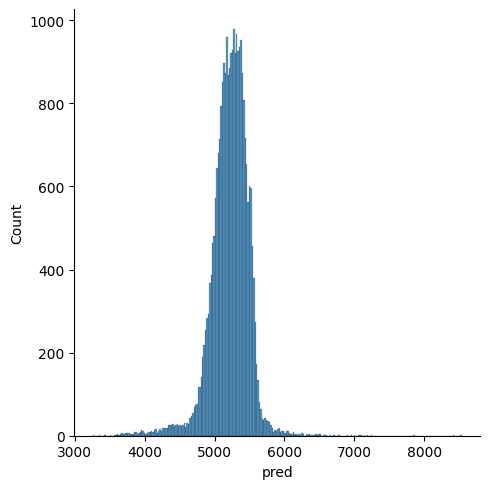

In [27]:
sns.displot(oof_df["pred"])
plt.show()